Модели ARMA

### Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [3]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

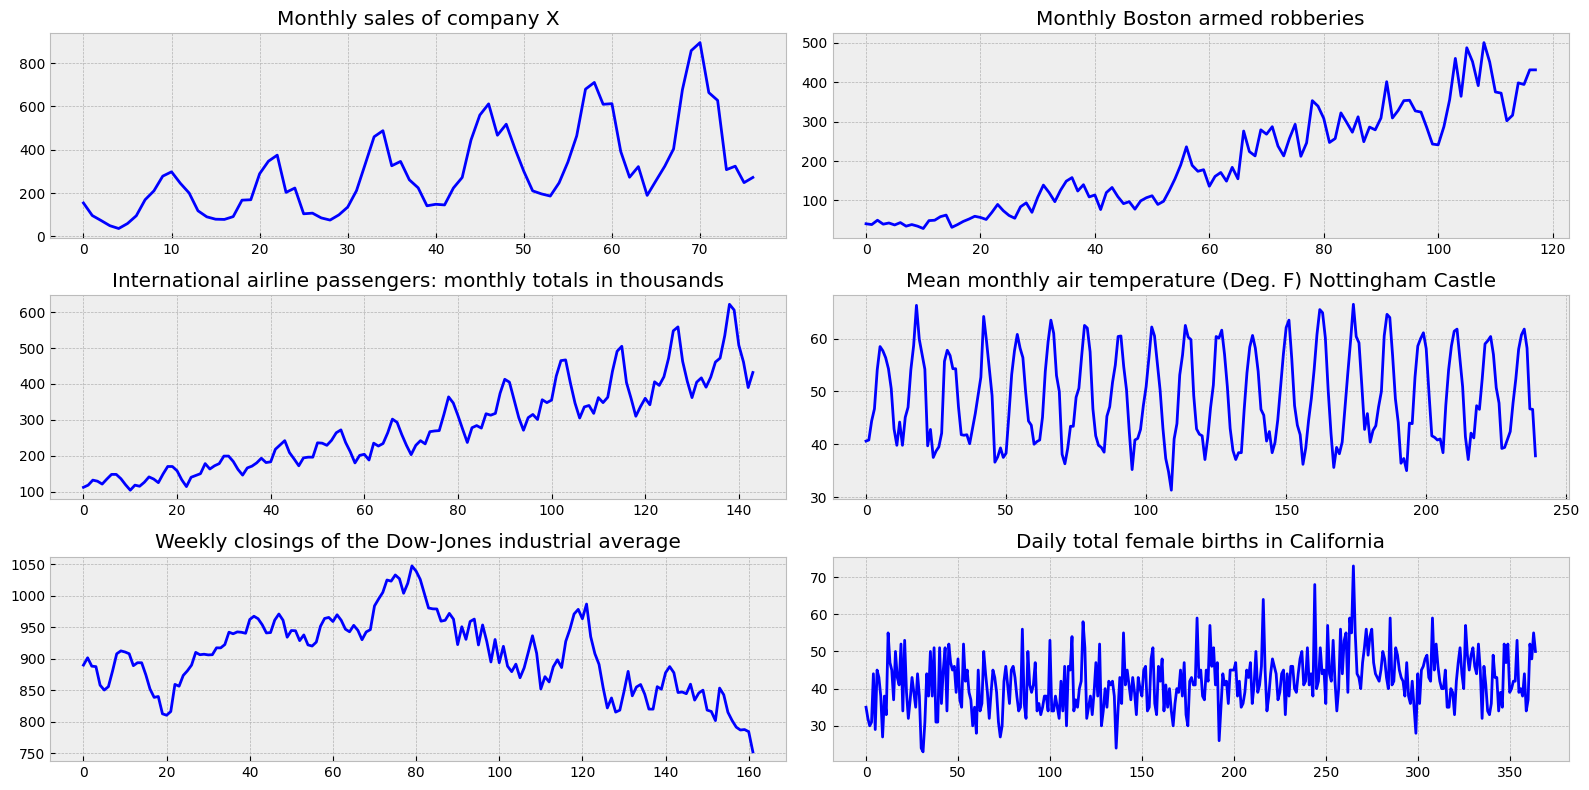

In [4]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [5]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### Выбор стационарного и не стационарного ряда

Не стационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


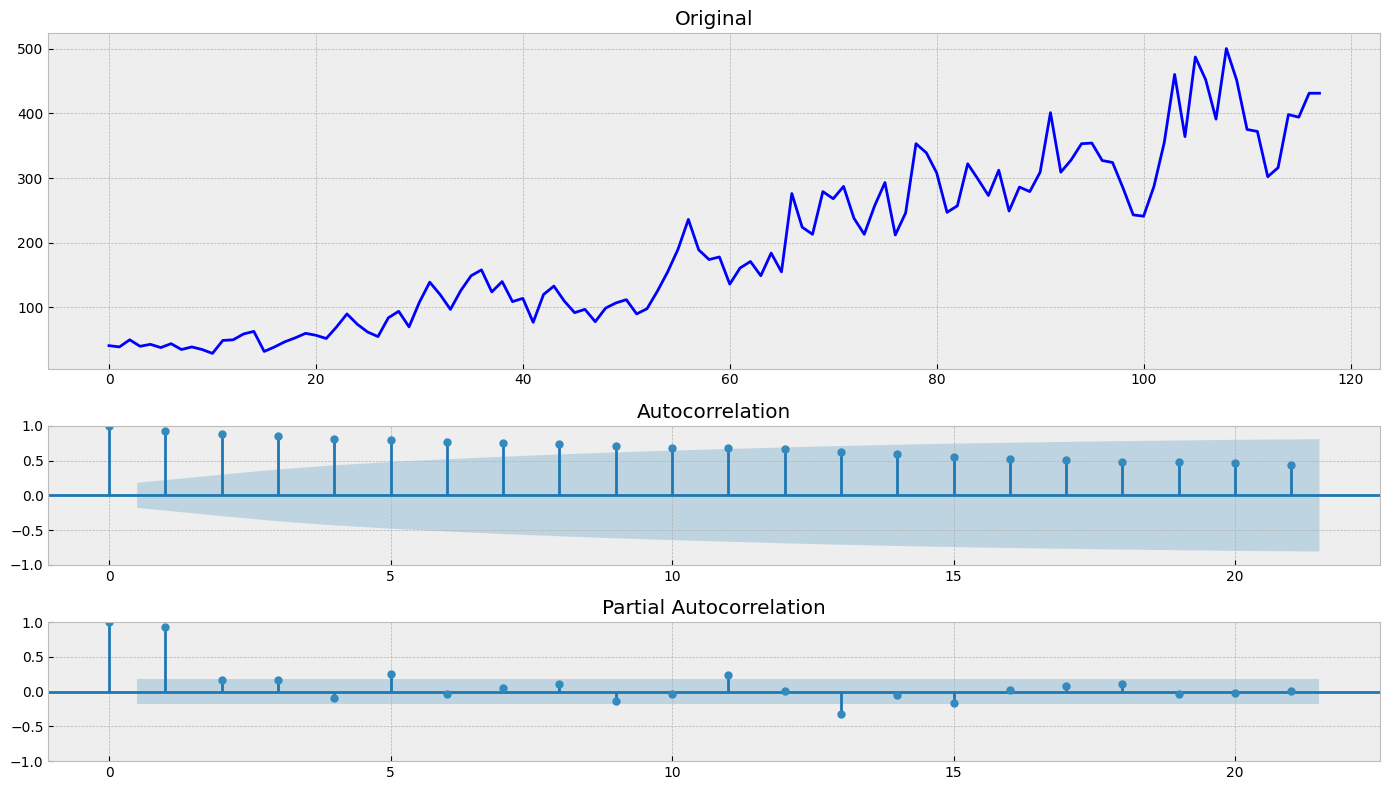

In [7]:
non_stationary_series = all_series["Monthly Boston armed robberies"]
tsplot(non_stationary_series)

Стационарный

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


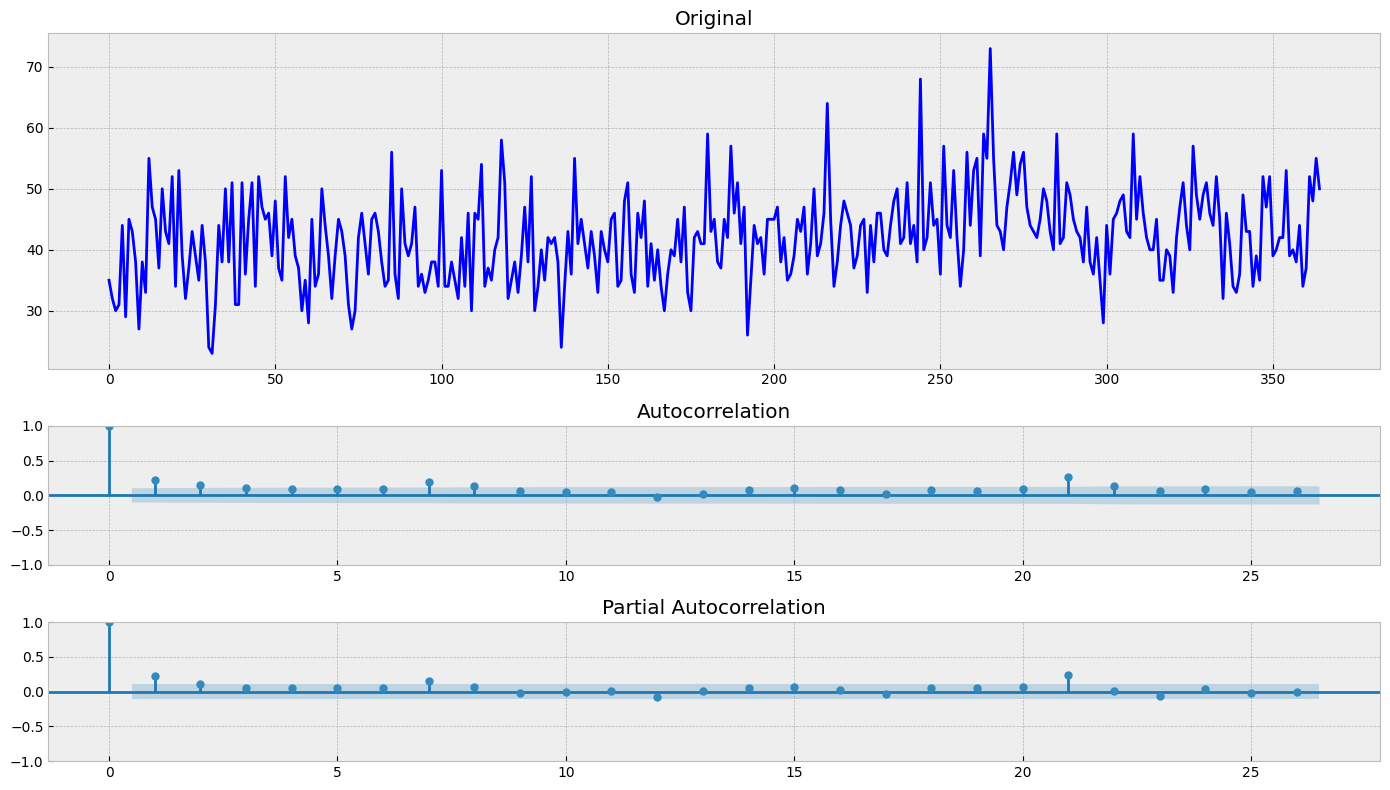

In [8]:
stationary_series = all_series["Daily total female births in California"]
tsplot(stationary_series)

### Построение модели ARIMA

In [86]:
from statsmodels.graphics.tsaplots import plot_predict
import warnings

def arima(series):
  best_aic = np.inf
  best_order = None
  best_mdl = None

  for i in range(5):
      for d in range(5):
          for j in range(5):
              try:
                  tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit()
                  tmp_aic = tmp_mdl.aic
                  if tmp_aic < best_aic:
                      best_aic = tmp_aic
                      best_order = (i, d, j)
                      best_mdl = tmp_mdl
              except: continue


  print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
  return best_mdl


def show(series, model):
  plt.figure(figsize=(14,8))
  fig, ax = plt.subplots()
  ax = series.loc[len(series)//2:].plot(ax=ax)
  plot_predict(model, len(series)-15, len(series)+10, ax=ax)
  plt.show()

In [74]:
warnings.filterwarnings('ignore')
non_stationary_model = arima(non_stationary_series)

aic: 1180.69825 | order: (4, 2, 4)


In [75]:
stationary_model = arima(stationary_series)

aic: 2458.21401 | order: (3, 1, 4)


Results of Dickey-Fuller Test:
Test Statistic                -1.083706e+01
p-value                        1.651796e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


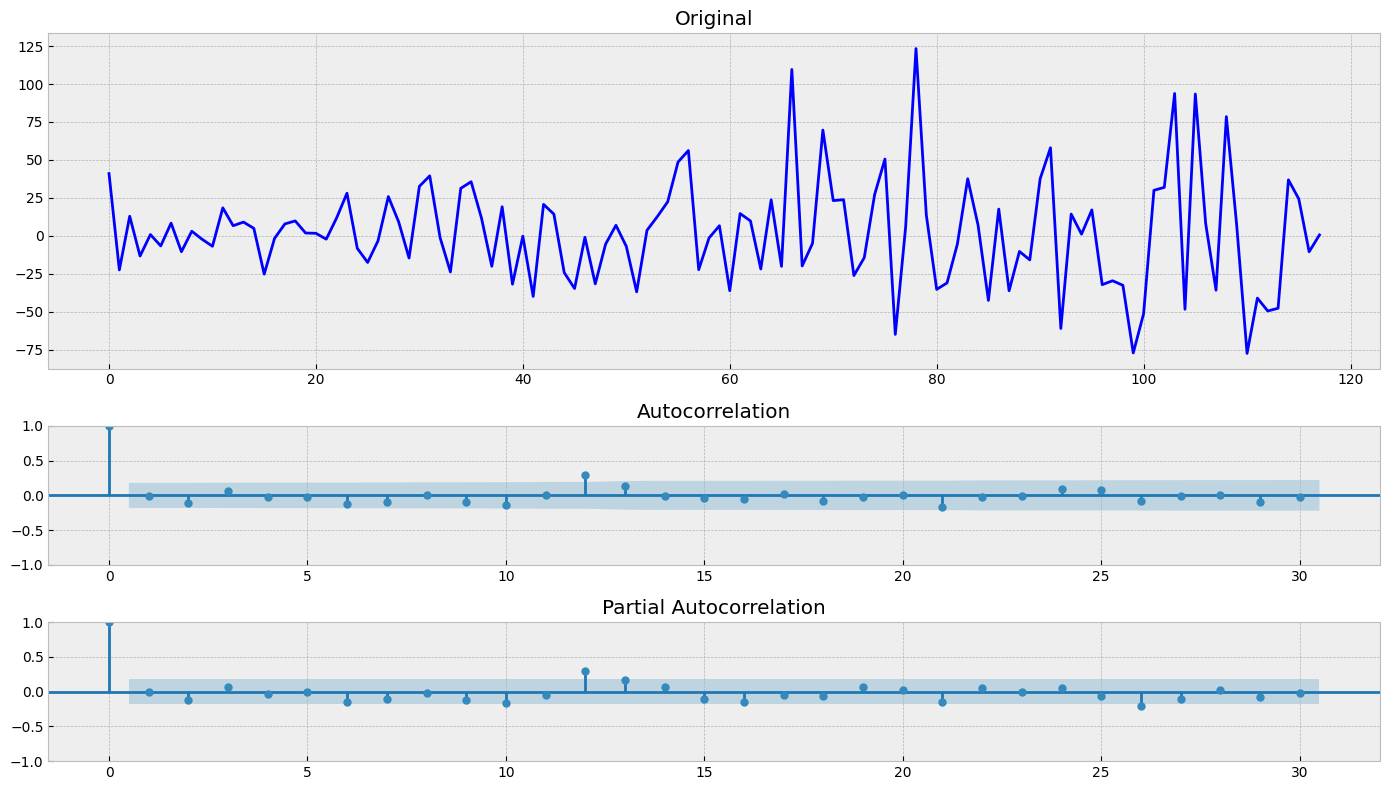

In [87]:
tsplot(non_stationary_model.resid, lags=30)

<Figure size 1400x800 with 0 Axes>

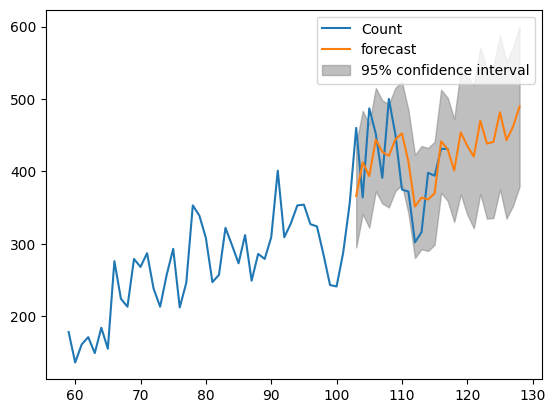

In [88]:
show(non_stationary_series, non_stationary_model)

Results of Dickey-Fuller Test:
Test Statistic                 -19.267578
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


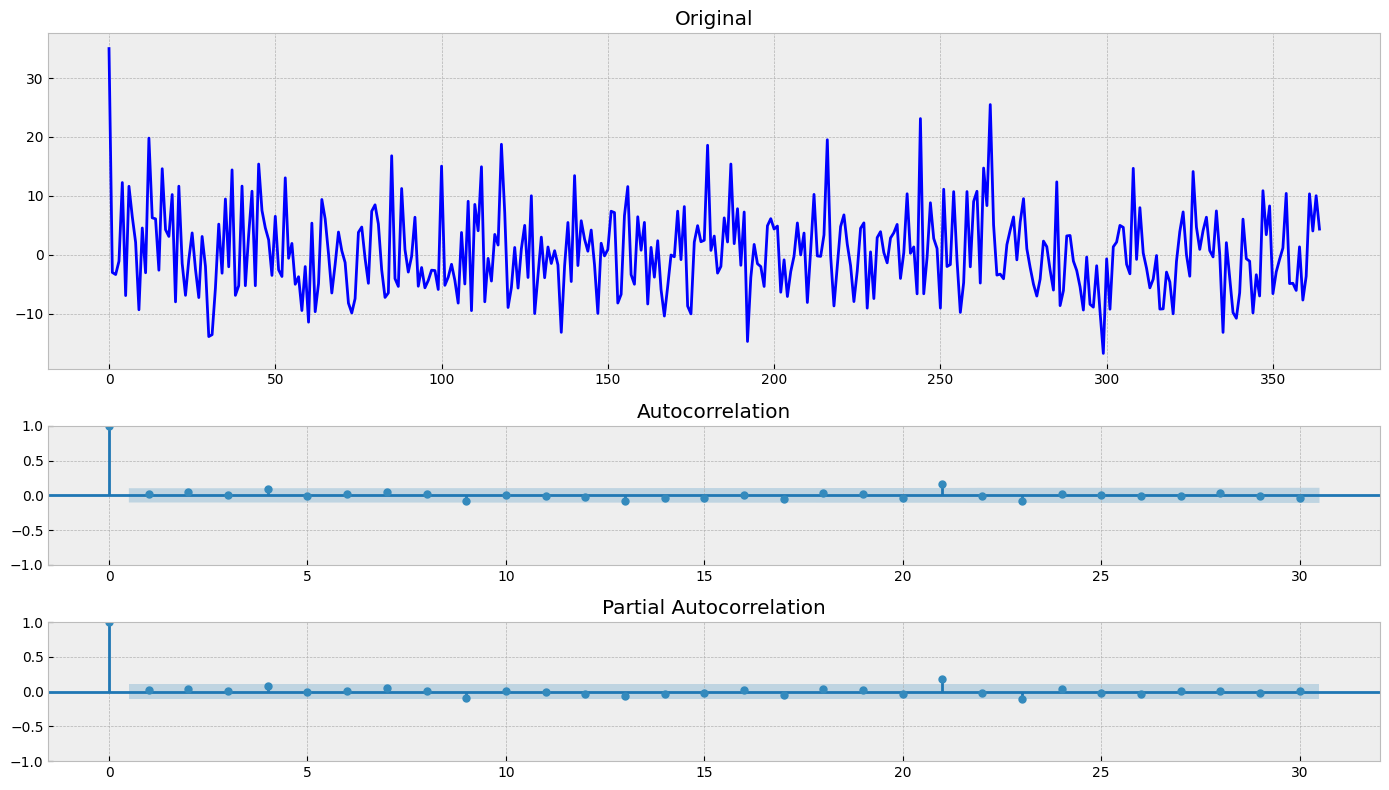

In [89]:
tsplot(stationary_model.resid, lags=30)

<Figure size 1400x800 with 0 Axes>

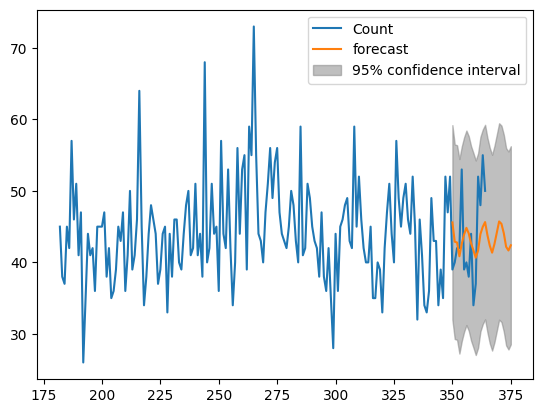

In [90]:
show(stationary_series, stationary_model)

### Вывод

1. Выбрал два ряда - стационарный и не стационарный
2. Построил две модели ARIMA

Для не стационарного ряда видим, что коэффициент aic гораздо меньше чем для стационарного ряда. Получается модель ARIMA для не стационарного ряда больше совпадает с самим рядом, что можно заметить на графиках с предсказаниями.

Так как модели ARIMA не дают точных предсказаний, то главное что мы можем увидеть на графиках, так это доверительные интервалы.